# Visualizing and classifying EEG data

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from joblib import Memory

%matplotlib inline

In [4]:
directory_root = '/Volumes/Transcend/Data/SeizurePrediction/'
root_directory_contents = os.listdir(directory_root)
print('\n'.join(root_directory_contents))

.DS_Store
cache
Dog_1
Dog_2
Dog_3
Dog_4
Dog_5
journal.pone.0081920.PDF
Patient_1
Patient_2
sampleSubmission.csv


## Accessing the data

In [5]:
def species_patientID(species, patientID):
    assert species in ['dog', 'patient']
    return species.capitalize() + '_' + str(patientID)

def convert_ictaltype(ictaltype):
    assert ictaltype in ['inter', 'pre', 'test']
    # Append ictal when necessary, shortening function arguments when possible
    if ictaltype != 'test':
        ictaltype += 'ictal'
    return ictaltype

def data_filename(sampleID, ictaltype, species='dog', patientID=1):
    ictaltype = convert_ictaltype(ictaltype)
    sub_directory = species_patientID(species, patientID)
    # Technically same variable as above, but perhaps more readable
    patient_str = species_patientID(species, patientID)
    filename_string = '%s/%s_%s_segment_%04d.mat'
    filename_variables = (sub_directory, patient_str, ictaltype, sampleID)
    filename = directory_root + filename_string % filename_variables
    return filename

print(data_filename(1, 'pre'))
print(data_filename(101, 'inter'))
print(data_filename(42, 'test'))

/Volumes/Transcend/Data/SeizurePrediction/Dog_1/Dog_1_preictal_segment_0001.mat
/Volumes/Transcend/Data/SeizurePrediction/Dog_1/Dog_1_interictal_segment_0101.mat
/Volumes/Transcend/Data/SeizurePrediction/Dog_1/Dog_1_test_segment_0042.mat


In [6]:
def retrieve_temporal_data(sampleID, ictaltype, species='dog', patientID=1):
    filename = data_filename(sampleID, ictaltype, species, patientID)
    ictaltype = convert_ictaltype(ictaltype)
    dictionary_key = '%s_segment_%d' % (ictaltype, sampleID)
    example = loadmat(filename)
    return example[dictionary_key][0][0][0]

interictal_example = retrieve_temporal_data(1, 'inter')
preictal_example = retrieve_temporal_data(1, 'pre')
test_example = retrieve_temporal_data(1, 'test')
print(interictal_example.shape)

(16, 239766)


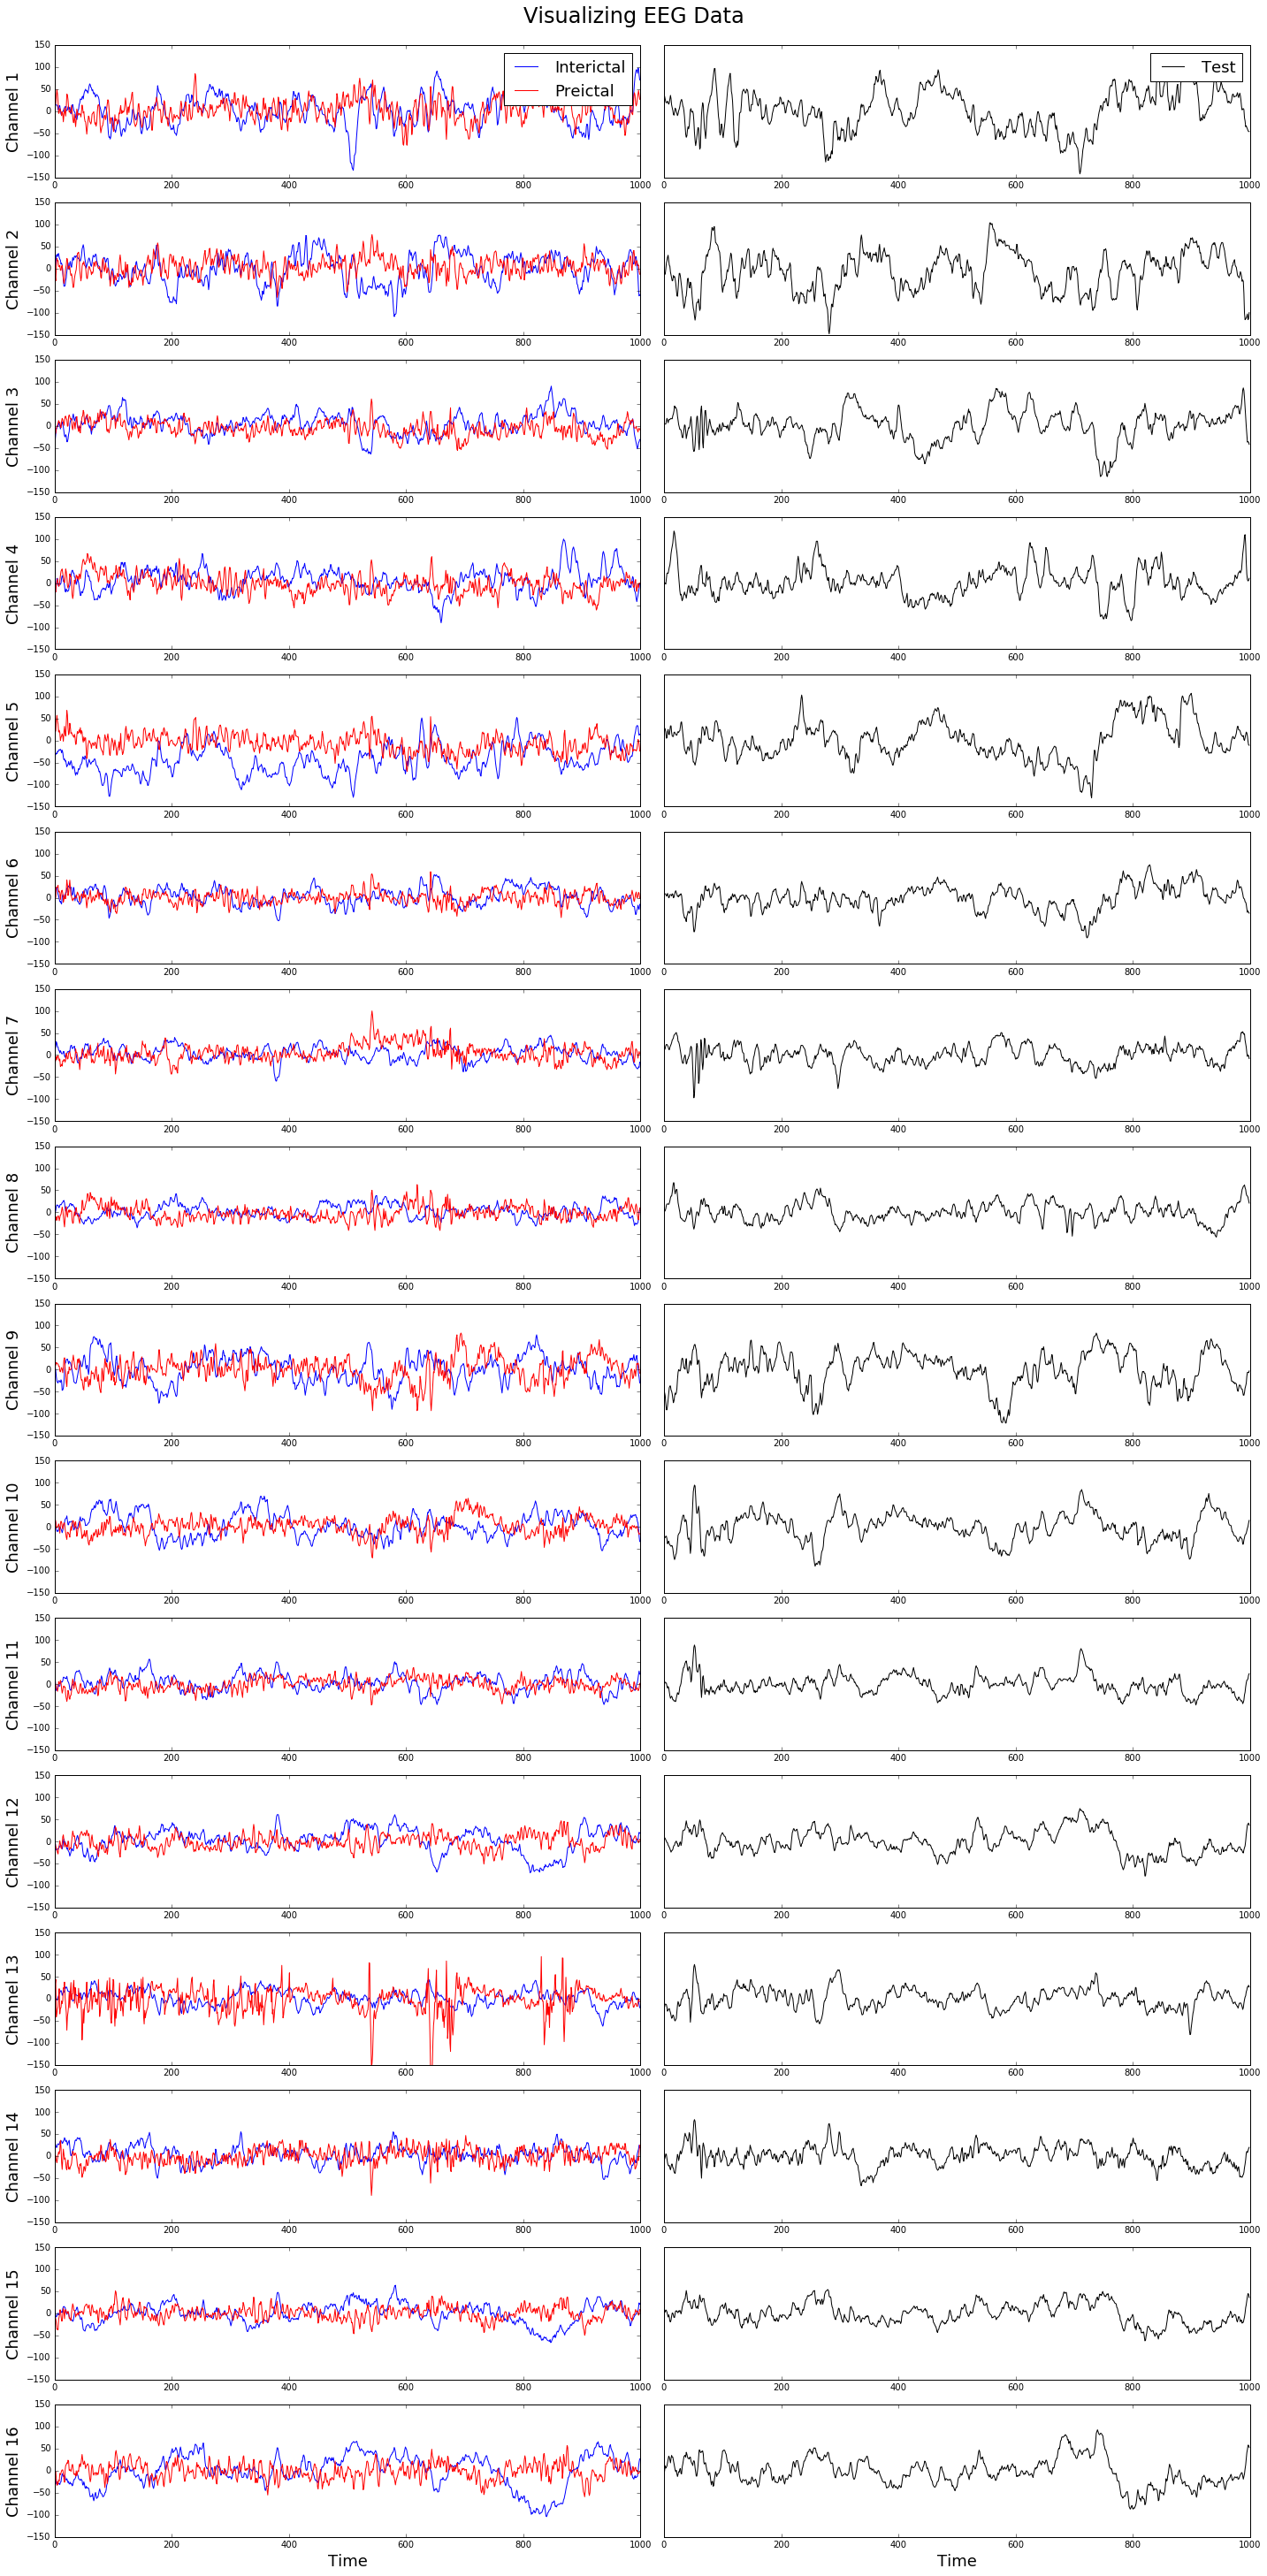

In [7]:
number_of_samples = 1000
time = np.arange(number_of_samples)
assert interictal_example.shape[0] == preictal_example.shape[0]
assert test_example.shape[0] == preictal_example.shape[0]
number_of_channels = interictal_example.shape[0]

fig, axs = plt.subplots(number_of_channels, 2, figsize=(20, 40))
for i in range(16):
    # Left columns
    interictal_channel = interictal_example[i,:number_of_samples]
    preictal_channel = preictal_example[i,:number_of_samples]
    interictal_line, = axs[i][0].plot(time, interictal_channel, color='blue')
    preictal_line, = axs[i][0].plot(time, preictal_channel, color='red')
    axs[i][0].set_ylim([-150, 150])
    axs[i][0].set_ylabel('Channel %d' % (i+1), fontsize=18)
    
    # Right column
    test_channel = test_example[i,:number_of_samples]
    test_line, = axs[i][1].plot(time, test_channel, color='black')
    axs[i][1].set_ylim([-150, 150])
    axs[i][1].yaxis.set_visible(False)
axs[0][0].legend((interictal_line, preictal_line), ('Interictal', 'Preictal'), fontsize=18)
axs[0][1].legend((test_line,), ('Test',), fontsize=18)

axs[number_of_channels-1][0].set_xlabel('Time', fontsize=18)
axs[number_of_channels-1][1].set_xlabel('Time', fontsize=18)
fig.suptitle('Visualizing EEG Data', y=1.01, fontsize=24)
plt.tight_layout()
plt.show()

In [8]:
cache_directory = directory_root + 'cache'
mem = Memory(cachedir=cache_directory, verbose=0)

@mem.cache
def retrieve_power_data(sampleID, ictaltype, species='dog', patientID=1):
    temporal_data = retrieve_temporal_data(sampleID, ictaltype, species, patientID)
    frequency_data = np.fft.fft(temporal_data)
    return np.abs(frequency_data)

def extract_pib_features(bins, sample, ictal, species='dog', patient=1):
    data = retrieve_power_data(sample, ictal, species, patient)
    max_power = np.max(data)
    pib, _ = np.histogram(data/max_power, bins=bins)
    return pib

bins = np.array([0, .001, .005, .01, 1])
number_of_samples = 24
interictal_features = np.zeros((number_of_samples, 3))
preictal_features = np.zeros((number_of_samples, 3))
for i in range(number_of_samples):
    current_interictal_features = extract_pib_features(bins, i+1, 'inter')
    current_preictal_features = extract_pib_features(bins, i+1, 'pre')
    interictal_features[i,:] = current_interictal_features[:-1]
    preictal_features[i,:] = current_preictal_features[:-1]

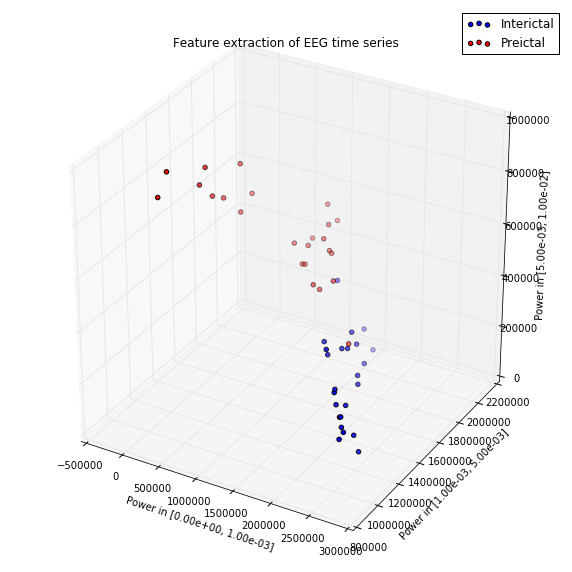

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(interictal_features[:,0],
           interictal_features[:,1],
           interictal_features[:,2], c='blue', label='Interictal')
ax.scatter(preictal_features[:,0],
           preictal_features[:,1],
           preictal_features[:,2], c='red', label='Preictal')
ax.set_xlabel('Power in [%.2e, %.2e]' % (bins[0], bins[1]))
ax.set_ylabel('Power in [%.2e, %.2e]' % (bins[1], bins[2]))
ax.set_zlabel('Power in [%.2e, %.2e]' % (bins[2], bins[3]))
ax.set_title('Feature extraction of EEG time series')
ax.legend()
plt.show()